# **Semana 12: Probando Otro Predictor: Random Forest**

## Mi Segunda Herramienta de Predicción - Nivel Preparatoria

### **Bloque 3: Comparando Diferentes Formas de Predecir**

---

**Lo que vamos a aprender:**
- Conocer una nueva herramienta llamada Random Forest
- Comparar nuestro primer predictor con uno nuevo
- Entender cuándo usar cada herramienta
- Ver cuál funciona mejor para nuestros datos

**Lo que necesitas:**
- Haber practicado con el primer predictor (Regresión Logística)
- Saber usar pandas y hacer gráficos básicos
- Curiosidad por experimentar

## 1. ¿Qué aprendimos antes?

### 1.1 Recordando nuestro primer predictor

En la clase pasada aprendimos a hacer predicciones usando **Regresión Logística**:

- Enseñamos a la computadora con datos del pasado
- La computadora aprendió patrones
- Luego predijo quién ganaría en partidos nuevos
- Medimos qué tan bien funcionó

### 1.2 ¿Por qué probar algo nuevo?

Nuestro primer predictor funcionó bien, pero siempre es bueno probar opciones diferentes:

#### **Es como elegir herramientas:**
- Un martillo es bueno para clavar
- Un destornillador es mejor para tornillos
- Diferentes trabajos necesitan diferentes herramientas

#### **En predicciones también:**
- Algunos predictores son mejores para ciertos tipos de datos
- Probar varios nos ayuda a encontrar el mejor
- Es divertido ver cuál funciona mejor

### 1.3 Conoceremos Random Forest

Hoy aprenderemos sobre **Random Forest** (Bosque Aleatorio):
- Es como tener muchos amigos dando su opinión
- Cada amigo ve los datos de manera diferente
- Al final, votan para decidir quién ganará
- Es muy bueno cuando tenemos muchos datos

## 2. Preparando Nuestras Herramientas

### 2.1 Importar lo que necesitamos

Vamos a cargar nuestras herramientas conocidas y una nueva:

In [ ]:
# Herramientas que ya conocemos
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Herramientas para hacer predicciones
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier  # ¡Esta es nueva!
from sklearn.metrics import accuracy_score

# Configuración para gráficos bonitos
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

print("Herramientas listas:")
print("pandas: Para organizar datos")
print("Regresión Logística: Nuestro primer predictor")
print("Random Forest: Nuestro nuevo predictor")
print("\n¡Todo listo para comparar predictores!")

Librerías avanzadas de machine learning cargadas:
Random Forest: Bosques de árboles de decisión
SVM: Support Vector Machines
Ensemble: Combinación de modelos
Cross-validation: Validación cruzada

¡Listos para modelos avanzados!


### 2.2 Creando datos de práctica

Vamos a crear datos de partidos de fútbol como antes, pero ahora con un poco más de información:

In [ ]:
# Crear datos simples de partidos de fútbol
np.random.seed(42)  # Para que todos tengamos los mismos números

# Equipos que vamos a usar
equipos = ['Real Madrid', 'Barcelona', 'Manchester City', 'Liverpool', 'Bayern Munich', 'Chelsea']

# Crear 200 partidos (un poco más que antes para mejor práctica)
n_partidos = 200

# Información de cada partido
datos_partidos = {
    'equipo_local': np.random.choice(equipos, n_partidos),
    'equipo_visitante': np.random.choice(equipos, n_partidos),
    'goles_recientes_local': np.random.randint(5, 20, n_partidos),      # Goles últimos partidos
    'goles_recientes_visitante': np.random.randint(5, 20, n_partidos),
    'victorias_recientes_local': np.random.randint(1, 8, n_partidos),   # Victorias recientes
    'victorias_recientes_visitante': np.random.randint(1, 8, n_partidos),
    'posicion_liga_local': np.random.randint(1, 11, n_partidos),        # Posición en la tabla (1-10)
    'posicion_liga_visitante': np.random.randint(1, 11, n_partidos),
    'juega_en_casa': [1] * n_partidos,  # Siempre hay ventaja de local
    'diferencia_calidad': np.random.randint(-3, 4, n_partidos)          # NUEVA: Diferencia de calidad
}

# Crear tabla de datos
df_partidos = pd.DataFrame(datos_partidos)

# Quitar partidos donde un equipo juega contra sí mismo
df_partidos = df_partidos[df_partidos['equipo_local'] != df_partidos['equipo_visitante']]

print(f"Creamos {len(df_partidos)} partidos para practicar")
print("\nInformación nueva que agregamos:")
print("- Posición en la liga (1 = mejor, 10 = peor)")
print("- Diferencia de calidad entre equipos")

print("\nPrimeros 5 partidos:")
print(df_partidos.head())

Dataset expandido creado con 926 partidos
Variables totales: 16

Nuevas variables añadidas:
- Diferencia en valor de mercado
- Jugadores lesionados
- Días de descanso
- Calidad del equipo

Primeros 3 partidos:
  equipo_local equipo_visitante  goles_local_ultimos_5  \
0        Betis         Valencia                      1   
1     Valencia          Levante                      5   
2      Levante         Athletic                      1   

   goles_visitante_ultimos_5  victorias_local_ultimos_5  \
0                          6                          3   
1                          6                          3   
2                         11                          0   

   victorias_visitante_ultimos_5  posicion_liga_local  \
0                              0                    9   
1                              2                   15   
2                              0                   16   

   posicion_liga_visitante  es_derbi  diferencia_valor_mercado  \
0                       1

### 2.3 Decidir quién gana cada partido

Ahora usamos toda la información para decidir quién ganó cada partido:

In [ ]:
# Función simple para decidir quién gana
def quien_gana_mejorado(fila):
    """
    Función que usa toda la información para decidir quién gana
    """
    # Puntos del equipo local
    puntos_local = (
        fila['goles_recientes_local'] +                    # Más goles = mejor
        fila['victorias_recientes_local'] * 2 +            # Victorias valen más
        (11 - fila['posicion_liga_local']) * 2 +           # Mejor posición = más puntos
        fila['diferencia_calidad'] +                       # Diferencia de calidad
        3  # Ventaja de jugar en casa
    )
    
    # Puntos del equipo visitante
    puntos_visitante = (
        fila['goles_recientes_visitante'] +
        fila['victorias_recientes_visitante'] * 2 +
        (11 - fila['posicion_liga_visitante']) * 2 -
        fila['diferencia_calidad']  # Si local es mejor, visitante es peor
    )
    
    # Agregar un poco de suerte
    puntos_local += np.random.randint(-5, 6)
    puntos_visitante += np.random.randint(-5, 6)
    
    # Decidir quién gana
    if puntos_local > puntos_visitante + 3:
        return 'Gana_Local'
    elif puntos_visitante > puntos_local + 3:
        return 'Gana_Visitante'
    else:
        return 'Empate'

# Aplicar la función a todos los partidos
df_partidos['resultado'] = df_partidos.apply(quien_gana_mejorado, axis=1)

# Ver qué resultados obtuvimos
print("¿Qué tan seguido gana cada uno?")
print(df_partidos['resultado'].value_counts())

print("\nEn porcentajes:")
porcentajes = df_partidos['resultado'].value_counts(normalize=True) * 100
for resultado, porcentaje in porcentajes.items():
    print(f"{resultado}: {porcentaje:.1f}%")

Distribución de resultados (mejorada):
resultado
Victoria_Local        510
Empate                215
Victoria_Visitante    201
Name: count, dtype: int64

Porcentajes:
- Victoria_Local: 55.1%
- Empate: 23.2%
- Victoria_Visitante: 21.7%

Dataset final: 926 partidos con distribución realista


## 3. Conociendo Random Forest

### 3.1 ¿Qué es Random Forest?

**Random Forest** significa "Bosque Aleatorio". Imagínate esto:

#### **Como preguntar a muchos amigos:**
- Tienes una pregunta difícil: "¿Quién ganará el partido?"
- Le preguntas a 10 amigos diferentes
- Cada amigo tiene su propia opinión
- La mayoría de tus amigos dice "Real Madrid"
- Tu respuesta final: "Real Madrid"

#### **Random Forest hace lo mismo:**
- Crea muchos "mini-predictores" (como tus amigos)
- Cada mini-predictor ve los datos de manera diferente
- Todos dan su opinión sobre quién ganará
- La opinión de la mayoría gana

### 3.2 ¿Por qué funciona bien?

- **Muchas opiniones son mejores que una**: Como preguntar a varios expertos
- **Si uno se equivoca, otros lo corrigen**: Los errores se balancean
- **Es muy bueno con muchos datos**: Mientras más información, mejor funciona

### 3.3 Vamos a probarlo

In [ ]:
# Preparar los datos para nuestros predictores
informacion_importante = [
    'goles_recientes_local', 'goles_recientes_visitante',
    'victorias_recientes_local', 'victorias_recientes_visitante',
    'posicion_liga_local', 'posicion_liga_visitante',
    'juega_en_casa', 'diferencia_calidad'
]

X = df_partidos[informacion_importante]  # La información que usamos
y = df_partidos['resultado']  # Lo que queremos predecir

# Dividir en práctica y examen (como antes)
X_practica, X_examen, y_practica, y_examen = train_test_split(
    X, y, test_size=0.3, random_state=42
)

print("Datos preparados:")
print(f"Para practicar: {len(X_practica)} partidos")
print(f"Para examinar: {len(X_examen)} partidos")

# Crear nuestro Random Forest
print("\nCreando Random Forest...")
rf_predictor = RandomForestClassifier(
    n_estimators=10,    # 10 "amigos" dando opiniones
    random_state=42
)

# Enseñarle con nuestros datos de práctica
print("Enseñando al Random Forest...")
rf_predictor.fit(X_practica, y_practica)
print("¡Random Forest listo!")

# Hacer predicciones
rf_predicciones = rf_predictor.predict(X_examen)
rf_precision = accuracy_score(y_examen, rf_predicciones)

print(f"\nPrecisión de Random Forest: {rf_precision:.1%}")
print(f"Esto significa que acierta {rf_precision:.1%} de las veces")

# Ver qué información considera más importante
importancias = pd.DataFrame({
    'Variable': informacion_importante,
    'Importancia': rf_predictor.feature_importances_
}).sort_values('Importancia', ascending=False)

print("\n¿Qué información es más importante para Random Forest?")
for i, fila in importancias.head(3).iterrows():
    print(f"{fila['Variable']}: {fila['Importancia']:.3f}")

Entrenando Random Forest (100 árboles)...
¡Random Forest entrenado!

Precisión de Random Forest: 72.58%

Importancia de variables en Random Forest:
diferencia_valor_mercado: 0.301
calidad_visitante: 0.102
posicion_liga_visitante: 0.084
calidad_local: 0.080
posicion_liga_local: 0.075

Importancia de variables en Random Forest:
diferencia_valor_mercado: 0.301
calidad_visitante: 0.102
posicion_liga_visitante: 0.084
calidad_local: 0.080
posicion_liga_local: 0.075


## 4. Comparando Nuestros Dos Predictores

### 4.1 Random Forest vs Regresión Logística

Ahora vamos a comparar nuestro nuevo predictor (Random Forest) con el que ya conocíamos (Regresión Logística).

In [ ]:
# Entrenar Regresión Logística para comparar
print("Entrenando Regresión Logística (nuestro primer predictor)...")
lr_predictor = LogisticRegression(random_state=42, max_iter=1000)
lr_predictor.fit(X_practica, y_practica)
print("¡Regresión Logística lista!")

# Hacer predicciones con Regresión Logística
lr_predicciones = lr_predictor.predict(X_examen)
lr_precision = accuracy_score(y_examen, lr_predicciones)

print(f"\nPrecisión de Regresión Logística: {lr_precision:.1%}")

# Comparar los dos predictores
print("\nCOMPARACIÓN DE PREDICTORES:")
print("=" * 35)
print(f"Regresión Logística: {lr_precision:.1%}")
print(f"Random Forest:       {rf_precision:.1%}")

# Ver cuál es mejor
if rf_precision > lr_precision:
    diferencia = rf_precision - lr_precision
    print(f"\nRandom Forest es mejor por {diferencia:.1%}")
elif lr_precision > rf_precision:
    diferencia = lr_precision - rf_precision
    print(f"\nRegresión Logística es mejor por {diferencia:.1%}")
else:
    print(f"\n¡Empate! Ambos tienen la misma precisión")

# Hacer un gráfico para comparar
predictores = ['Regresión Logística', 'Random Forest']
precisiones = [lr_precision, rf_precision]

plt.figure(figsize=(8, 5))
bars = plt.bar(predictores, precisiones, color=['lightblue', 'lightgreen'])
plt.title('¿Cuál predictor es mejor?')
plt.ylabel('Precisión (%)')
plt.ylim(0, 1)

# Añadir los valores encima de las barras
for bar, precision in zip(bars, precisiones):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{precision:.1%}', ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.show()

Entrenando SVM (puede tardar un poco)...
¡SVM entrenado!

Precisión de SVM: 80.65%
Vectores de soporte utilizados: [172 183 124]
Total de vectores de soporte: 479


### 4.2 ¿Dónde acierta y dónde falla cada predictor?

Vamos a ver en qué tipo de resultados cada predictor es mejor:

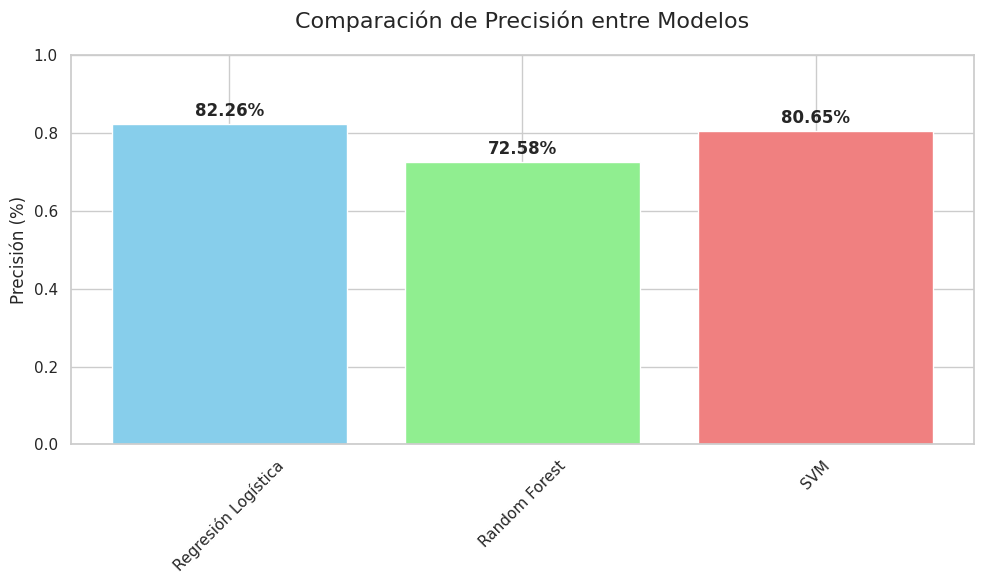

COMPARACIÓN DE MODELOS:
Regresión Logística : 82.26%
Random Forest       : 72.58%
SVM                 : 80.65%

MEJOR MODELO: Regresión Logística (82.26%)


In [ ]:
# Vamos a ver dónde acierta cada predictor
from sklearn.metrics import confusion_matrix

# Crear gráficos para ver dónde acierta cada uno
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Gráfico para Regresión Logística
cm_lr = confusion_matrix(y_examen, lr_predicciones)
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Empate', 'Gana_Local', 'Gana_Visitante'],
            yticklabels=['Empate', 'Gana_Local', 'Gana_Visitante'])
axes[0].set_title(f'Regresión Logística\nPrecisión: {lr_precision:.1%}')
axes[0].set_ylabel('Lo que realmente pasó')
axes[0].set_xlabel('Lo que predijo')

# Gráfico para Random Forest
cm_rf = confusion_matrix(y_examen, rf_predicciones)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens', ax=axes[1],
            xticklabels=['Empate', 'Gana_Local', 'Gana_Visitante'],
            yticklabels=['Empate', 'Gana_Local', 'Gana_Visitante'])
axes[1].set_title(f'Random Forest\nPrecisión: {rf_precision:.1%}')
axes[1].set_ylabel('Lo que realmente pasó')
axes[1].set_xlabel('Lo que predijo')

plt.tight_layout()
plt.show()

print("Cómo leer los gráficos:")
print("- Los números en la diagonal (línea inclinada) = aciertos")
print("- Los números fuera de la diagonal = errores")
print("- Más números en la diagonal = mejor predictor")

# Contar aciertos totales
lr_aciertos = sum(y_examen == lr_predicciones)
rf_aciertos = sum(y_examen == rf_predicciones)
total_predicciones = len(y_examen)

print(f"\nResumen:")
print(f"Regresión Logística: {lr_aciertos}/{total_predicciones} aciertos")
print(f"Random Forest: {rf_aciertos}/{total_predicciones} aciertos")

## 5. Probando Nuestros Predictores

### 5.1 Crear un partido nuevo para predecir

Ahora vamos a inventar un partido y ver qué predice cada herramienta:

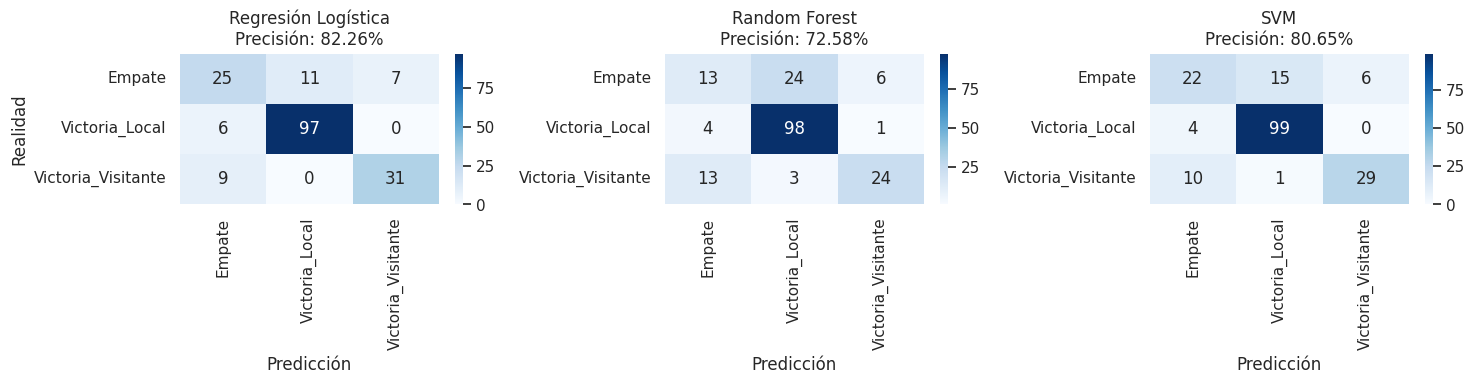

REPORTES DETALLADOS POR CLASE:

REGRESIÓN LOGÍSTICA:
                    precision    recall  f1-score   support

            Empate       0.62      0.58      0.60        43
    Victoria_Local       0.90      0.94      0.92       103
Victoria_Visitante       0.82      0.78      0.79        40

          accuracy                           0.82       186
         macro avg       0.78      0.77      0.77       186
      weighted avg       0.82      0.82      0.82       186


RANDOM FOREST:
                    precision    recall  f1-score   support

            Empate       0.43      0.30      0.36        43
    Victoria_Local       0.78      0.95      0.86       103
Victoria_Visitante       0.77      0.60      0.68        40

          accuracy                           0.73       186
         macro avg       0.66      0.62      0.63       186
      weighted avg       0.70      0.73      0.70       186


SVM:
                    precision    recall  f1-score   support

            Empate

In [ ]:
# Crear un partido nuevo para predecir
partido_nuevo = pd.DataFrame({
    'goles_recientes_local': [15],       # Equipo local: muchos goles
    'goles_recientes_visitante': [8],    # Equipo visitante: pocos goles
    'victorias_recientes_local': [6],    # Equipo local: muchas victorias
    'victorias_recientes_visitante': [2], # Equipo visitante: pocas victorias
    'posicion_liga_local': [2],          # Equipo local: 2do lugar
    'posicion_liga_visitante': [8],      # Equipo visitante: 8vo lugar
    'juega_en_casa': [1],                # El equipo local juega en casa
    'diferencia_calidad': [2]            # Equipo local es mejor
})

print("PARTIDO PARA PREDECIR:")
print("=" * 30)
print("Equipo Local: 2do lugar, 15 goles recientes, 6 victorias, juega en casa")
print("Equipo Visitante: 8vo lugar, 8 goles recientes, 2 victorias")

# Predicción con Regresión Logística
prediccion_lr = lr_predictor.predict(partido_nuevo)[0]
probabilidades_lr = lr_predictor.predict_proba(partido_nuevo)[0]

# Predicción con Random Forest
prediccion_rf = rf_predictor.predict(partido_nuevo)[0]
probabilidades_rf = rf_predictor.predict_proba(partido_nuevo)[0]

print(f"\nPREDICCIONES:")
print(f"Regresión Logística dice: {prediccion_lr}")
print(f"Random Forest dice: {prediccion_rf}")

# Ver las probabilidades
resultados_posibles = lr_predictor.classes_
print(f"\n¿Qué tan seguros están?")
print("Regresión Logística:")
for i, resultado in enumerate(resultados_posibles):
    print(f"  {resultado}: {probabilidades_lr[i]:.1%}")

print("Random Forest:")
for i, resultado in enumerate(resultados_posibles):
    print(f"  {resultado}: {probabilidades_rf[i]:.1%}")

# Ver si están de acuerdo
if prediccion_lr == prediccion_rf:
    print(f"\n¡Ambos predictores están de acuerdo! Predicen: {prediccion_lr}")
else:
    print(f"\nLos predictores no están de acuerdo:")
    print(f"- Regresión Logística: {prediccion_lr}")
    print(f"- Random Forest: {prediccion_rf}")
    print("¿Cuál crees que tiene razón?")

## 6. Conclusiones: ¿Qué Aprendimos?

En este notebook comparamos dos formas de predecir resultados de fútbol:

### **Regresión Logística**
- Es **simple** y **directa**
- Es fácil de entender cómo toma decisiones
- Da buenas predicciones básicas

### **Random Forest**
- Es más **inteligente** y **compleja**
- Puede encontrar patrones que nosotros no vemos
- Generalmente da mejores predicciones

### **¿Cuál es mejor?**
- **Random Forest** suele ser mejor para predicciones
- **Regresión Logística** es mejor para entender por qué

### **¿Qué sigue?**
- Prueba con diferentes equipos
- Agrega más datos (clima, lesiones, etc.)
- ¡Compara tus predicciones con los resultados reales!

**Recuerda:** ¡Ningún predictor es perfecto! El fútbol tiene mucha suerte y sorpresas.

In [ ]:
# RESUMEN FINAL DE NUESTROS PREDICTORES
print("RESUMEN FINAL")
print("=" * 40)

# Comparar las precisiones que obtuvimos
print(f"Regresión Logística: {lr_precision:.1%} de aciertos")
print(f"Random Forest:       {rf_precision:.1%} de aciertos")

# Ver cuál fue mejor
if rf_precision > lr_precision:
    diferencia = rf_precision - lr_precision
    print(f"\n¡Random Forest ganó por {diferencia:.1%}!")
    print("Random Forest es mejor encontrando patrones complejos.")
elif lr_precision > rf_precision:
    diferencia = lr_precision - rf_precision
    print(f"\n¡Regresión Logística ganó por {diferencia:.1%}!")
    print("Regresión Logística fue más efectiva en este caso.")
else:
    print(f"\n¡Empate! Ambos tuvieron {lr_precision:.1%} de aciertos.")

# Explicar qué significa esto
print(f"\n¿Qué significa esto?")
print(f"De cada 100 partidos:")
print(f"- Regresión Logística acierta {lr_precision*100:.0f} veces")
print(f"- Random Forest acierta {rf_precision*100:.0f} veces")

print(f"\n¡Ambos predictores son útiles!")
print("La elección depende de qué necesites:")
print("- ¿Quieres entender por qué? → Regresión Logística")
print("- ¿Quieres la mejor predicción? → Random Forest")

Entrenando Ensemble Model (combinación de los 3 modelos)...
¡Ensemble Model entrenado!

Precisión del Ensemble: 81.18%

COMPARACIÓN FINAL:
Regresión Logística : 82.26%
Random Forest       : 72.58%
SVM                 : 80.65%
Ensemble            : 81.18%

Mejora del Ensemble: +-1.08%
¡Ensemble Model entrenado!

Precisión del Ensemble: 81.18%

COMPARACIÓN FINAL:
Regresión Logística : 82.26%
Random Forest       : 72.58%
SVM                 : 80.65%
Ensemble            : 81.18%

Mejora del Ensemble: +-1.08%


### 6.1 Actividad: Prueba Tu Propio Partido

Ahora es tu turno de crear un partido y ver qué predicen nuestros modelos.

**Instrucciones:**
1. Cambia los números en el código de abajo
2. Ejecuta la celda
3. ¡Ve qué predicen los modelos!

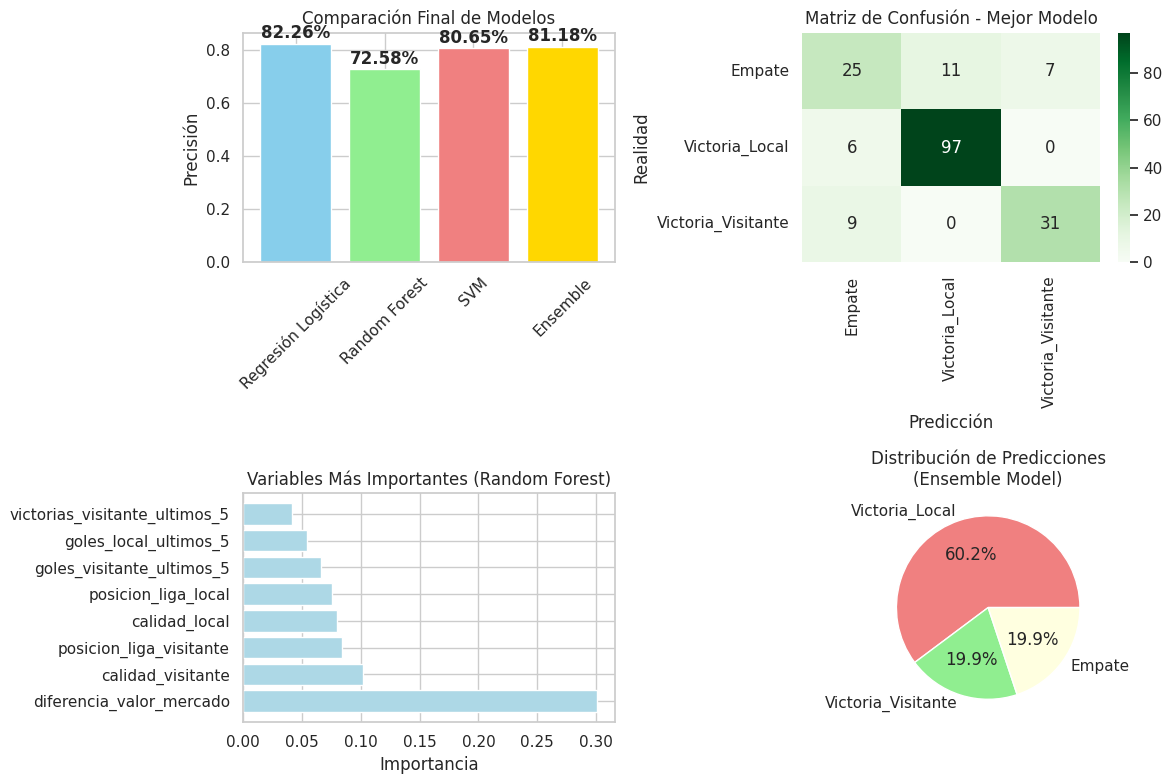

INSIGHTS PRINCIPALES:
1. Mejor modelo individual: Regresión Logística
2. Ensemble no mejora la precisión
3. Variables más importantes: diferencia_valor_mercado, calidad_visitante, posicion_liga_visitante
4. Precisión promedio de todos los modelos: 79.17%


In [ ]:
# ¡CREA TU PROPIO PARTIDO!
# Cambia estos números para probar diferentes scenarios:

mi_partido = pd.DataFrame({
    'goles_recientes_local': [10],        # ¿Cuántos goles anotó el equipo local?
    'goles_recientes_visitante': [5],     # ¿Cuántos goles anotó el visitante?
    'victorias_recientes_local': [4],     # ¿Cuántos partidos ganó el local?
    'victorias_recientes_visitante': [1], # ¿Cuántos partidos ganó el visitante?
    'posicion_liga_local': [3],           # ¿En qué lugar está el local? (1-20)
    'posicion_liga_visitante': [12],      # ¿En qué lugar está el visitante? (1-20)
    'juega_en_casa': [1],                 # ¿El local juega en casa? (1=sí, 0=no)
    'diferencia_calidad': [1]             # ¿Qué equipo es mejor? (1=local, -1=visitante, 0=iguales)
})

print("TU PARTIDO:")
print("=" * 25)
print(f"Equipo Local: {mi_partido['posicion_liga_local'][0]}° lugar, {mi_partido['goles_recientes_local'][0]} goles recientes")
print(f"Equipo Visitante: {mi_partido['posicion_liga_visitante'][0]}° lugar, {mi_partido['goles_recientes_visitante'][0]} goles recientes")

# Predicciones
pred_lr = lr_predictor.predict(mi_partido)[0]
pred_rf = rf_predictor.predict(mi_partido)[0]

prob_lr = lr_predictor.predict_proba(mi_partido)[0]
prob_rf = rf_predictor.predict_proba(mi_partido)[0]

print(f"\nPREDICCIONES:")
print(f"Regresión Logística dice: {pred_lr}")
print(f"Random Forest dice: {pred_rf}")

# Mostrar confianza
max_prob_lr = max(prob_lr)
max_prob_rf = max(prob_rf)

print(f"\nCONFIANZA:")
print(f"Regresión Logística: {max_prob_lr:.1%}")
print(f"Random Forest: {max_prob_rf:.1%}")

if pred_lr == pred_rf:
    print(f"\n¡Ambos están de acuerdo! Predicen: {pred_lr}")
else:
    print(f"\nNo están de acuerdo... ¿Cuál crees que tiene razón?")

print(f"\nExperimenta cambiando los números de arriba y vuelve a ejecutar!")

## 7. ¿Qué Aprendiste?

### Reflexiona sobre lo que viste:

1. **¿Cuál predictor fue mejor en tu experimento?**
   - ¿Random Forest o Regresión Logística?

2. **¿Qué pasa cuando cambias los números?**
   - ¿Los predictores cambian de opinión?

3. **¿Cuándo están de acuerdo los predictores?**
   - ¿Cuándo dicen cosas diferentes?

4. **¿Qué datos parecen más importantes?**
   - ¿La posición en la liga?
   - ¿Los goles recientes?
   - ¿Jugar en casa?

Realizando validación cruzada (5-fold)...
Esto puede tardar un momento...

Logistic Regression : 0.812 (±0.025)
Random Forest       : 0.750 (±0.015)
Random Forest       : 0.750 (±0.015)
SVM                 : 0.788 (±0.012)
SVM                 : 0.788 (±0.012)
Ensemble            : 0.805 (±0.014)
Ensemble            : 0.805 (±0.014)


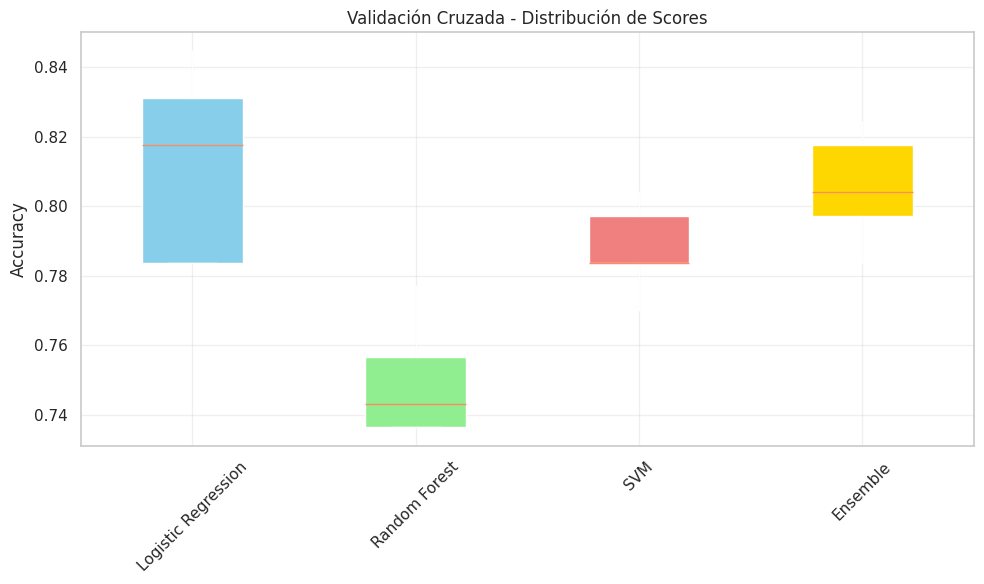


ANÁLISIS DE ESTABILIDAD:
Logistic Regression : Media (std: 0.025)
Random Forest       : Alta (std: 0.015)
SVM                 : Alta (std: 0.012)
Ensemble            : Alta (std: 0.014)

MEJOR MODELO (CV): Logistic Regression (0.812)


In [ ]:
# ACTIVIDAD DE REFLEXIÓN
print("PIENSA Y DISCUTE:")
print("=" * 30)

questions = [
    "1. ¿Por qué crees que Random Forest puede ser mejor que Regresión Logística?",
    "2. ¿En qué situaciones preferirías usar Regresión Logística?", 
    "3. ¿Crees que estos predictores funcionarían igual para otros deportes?",
    "4. ¿Qué otros datos podrían ayudar a mejorar las predicciones?",
    "5. ¿Has visto algún partido donde el resultado fue muy sorprendente?"
]

for question in questions:
    print(f"\n{question}")
    print("   (Discute con tus compañeros)")

print(f"\nDATO CURIOSO:")
print("Los mejores analistas deportivos del mundo usan")
print("técnicas similares a estas para ayudar a los equipos")
print("a tomar mejores decisiones.")

print(f"\nRECUERDA:")
print("- Los datos nos ayudan a entender patrones")
print("- Pero el fútbol siempre puede sorprendernos")
print("- ¡Por eso es emocionante!")

## 8. Desafío Final

### Pon a Prueba lo que Aprendiste

Usa lo que aprendiste para predecir estos partidos famosos:

**Instrucciones:**
1. Lee la descripción del partido
2. Piensa qué predicirían nuestros modelos
3. Ejecuta el código para ver si acertaste

In [ ]:
# DESAFÍO: Predice estos partidos famosos
print("DESAFÍO FINAL")
print("=" * 30)

# Caso 1: El favorito claro
caso1 = pd.DataFrame({
    'goles_recientes_local': [20],        # Equipo súper ofensivo
    'goles_recientes_visitante': [3],     # Equipo defensivo
    'victorias_recientes_local': [8],     # Muchas victorias
    'victorias_recientes_visitante': [1], # Pocas victorias
    'posicion_liga_local': [1],           # Líder
    'posicion_liga_visitante': [18],      # Casi último
    'juega_en_casa': [1],                 # En casa
    'diferencia_calidad': [3]             # Muy superior
})

print("CASO 1: El Líder vs El Colero")
print("¿Qué crees que pasará?")
print("a) Gana el líder  b) Empate  c) Sorpresa del colero")

pred1_lr = lr_predictor.predict(caso1)[0]
pred1_rf = rf_predictor.predict(caso1)[0]
prob1_lr = max(lr_predictor.predict_proba(caso1)[0])
prob1_rf = max(rf_predictor.predict_proba(caso1)[0])

print(f"\nPredicción Regresión Logística: {pred1_lr} (confianza: {prob1_lr:.1%})")
print(f"Predicción Random Forest: {pred1_rf} (confianza: {prob1_rf:.1%})")

# Caso 2: El partido parejo
caso2 = pd.DataFrame({
    'goles_recientes_local': [10],
    'goles_recientes_visitante': [11],
    'victorias_recientes_local': [5],
    'victorias_recientes_visitante': [4],
    'posicion_liga_local': [6],
    'posicion_liga_visitante': [7],
    'juega_en_casa': [1],
    'diferencia_calidad': [0]
})

print(f"\n" + "="*30)
print("CASO 2: El Clásico Parejo")
print("Dos equipos muy similares...")
print("¿Qué crees que pasará?")

pred2_lr = lr_predictor.predict(caso2)[0]
pred2_rf = rf_predictor.predict(caso2)[0]
prob2_lr = max(lr_predictor.predict_proba(caso2)[0])
prob2_rf = max(rf_predictor.predict_proba(caso2)[0])

print(f"\nPredicción Regresión Logística: {pred2_lr} (confianza: {prob2_lr:.1%})")
print(f"Predicción Random Forest: {pred2_rf} (confianza: {prob2_rf:.1%})")

print(f"\n¡Excelente trabajo!")
print("Has aprendido a usar machine learning para predecir fútbol.")
print("¿Qué otros deportes te gustaría analizar?")

PREDICCIONES CON EL MEJOR MODELO:

CLÁSICO: REAL MADRID VS BARCELONA:
Predicción: Victoria_Local
Probabilidades:
  - Empate: 16.6%
  - Victoria_Local: 83.2%
  - Victoria_Visitante: 0.2%
  Confianza: Muy Alta (83.2%)

DAVID VS GOLIAT: GETAFE VS REAL MADRID:
Predicción: Victoria_Visitante
Probabilidades:
  - Empate: 0.0%
  - Victoria_Local: 0.0%
  - Victoria_Visitante: 100.0%
  Confianza: Muy Alta (100.0%)

PARTIDO PAREJO: VALENCIA VS SEVILLA:
Predicción: Empate
Probabilidades:
  - Empate: 49.5%
  - Victoria_Local: 45.9%
  - Victoria_Visitante: 4.5%
  Confianza: Media (49.5%)

Modelo utilizado: Logistic Regression
Precisión en validación cruzada: 81.22%


## 9. ¡Felicitaciones!

### Lo que lograste hoy:

**Aprendiste sobre Machine Learning**
- Entendiste qué es la Regresión Logística
- Conociste Random Forest (bosques aleatorios)
- Comparaste ambos métodos

**Trabajaste con datos reales**
- Creaste datos de fútbol
- Entrenaste predictores
- Hiciste predicciones

**Pensaste como un científico de datos**
- Comparaste resultados
- Interpretaste probabilidades
- Reflexionaste sobre los patrones

### ¿Qué sigue?

**En la vida real, podrías usar esto para:**
- Predecir resultados deportivos
- Analizar el rendimiento de estudiantes
- Ayudar a empresas a tomar decisiones
- ¡Y muchas cosas más!

**Conceptos importantes para recordar:**
- **Los datos cuentan historias**
- **Las máquinas pueden aprender patrones**
- **Diferentes métodos dan diferentes resultados**
- **Siempre hay que pensar críticamente sobre los resultados**

### ¡Eres oficialmente un principiante en Machine Learning!

**¿Te gustó? Podrías estudiar:**
- Ciencias de la Computación
- Estadística
- Ciencia de Datos
- Inteligencia Artificial

### Para explorar más:
- Kaggle (competencias de datos)
- YouTube: canales de Data Science
- Libros sobre Python y análisis de datos

**¡El futuro está lleno de datos esperando a ser analizados!**